# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [1]:
import requests


def extract_cifar_data(url, filename="cifar.tar.gz"):
    """Extracts the CIFAR-100 dataset and stores it as a gzipped file
    
    Arguments:
    url      -- URL where the dataset is hosted
    filename -- full path where the dataset will be written
    """
    # Request the data from the URL using requests.get
    r = requests.get(url)
    
    # Ensure the request was successful
    r.raise_for_status()
    
    # Write the content to a file in binary mode
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [2]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [3]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [4]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [5]:
# Feel free to explore the datasets
import pandas as pd

dataset_train.keys()
 


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [6]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [7]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
print(row)
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

[255 255 255 ...  10  59  79]


For a more concise version, consider the following:

In [8]:
# All in one:
#Channels are stacked depth-wise to form a 32x32x3 RGB image:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

Matplotlib is building the font cache; this may take a moment.


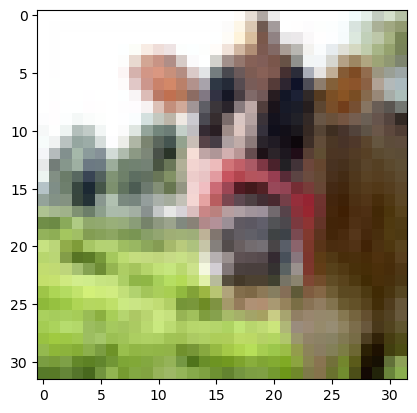

In [9]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [10]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [11]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [12]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [13]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [ ]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [14]:
import pandas as pd

# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles

# Find the label indexes for 'bicycle' and 'motorcycle'
# Decode label names from bytes to string
fine_label_names = [name.decode() for name in dataset_meta[b'fine_label_names']]

# Find the indexes for 'bicycle' and 'motorcycle'
bicycle_idx = fine_label_names.index('bicycle')
motorcycle_idx = fine_label_names.index('motorcycle')

print("Bicycle index:", bicycle_idx)       # For verification
print("Motorcycle index:", motorcycle_idx)




Bicycle index: 8
Motorcycle index: 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [15]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train['labels'].isin([bicycle_idx, motorcycle_idx ])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin([bicycle_idx, motorcycle_idx ])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)
print(f"TRAIN DF: {df_train.head()}")
print(f"TEST DF: {df_test.head()}")

TRAIN DF:                    filenames  labels  row
16         bike_s_000682.png       8   16
30         bike_s_000127.png       8   30
130       cycle_s_002598.png       8  130
152    minibike_s_000824.png      48  152
195  motorcycle_s_001856.png      48  195
TEST DF:                          filenames  labels  row
27        safety_bike_s_000390.png       8   27
28               bike_s_000658.png       8   28
116        velocipede_s_001744.png       8  116
161              bike_s_000643.png       8  161
319  ordinary_bicycle_s_000437.png       8  319


Now that the data is filtered for just our classes, we can save all our images.

In [ ]:
!mkdir ./train
!mkdir ./test

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def save_images(dataset, path="./train/"):
    os.makedirs(path, exist_ok=True)

    for i in range(len(dataset[b'data'])):
        #Grab the image data in row-major form
        img = dataset[b'data'][i]
    
        # Consolidated stacking/reshaping from earlier
        target = np.dstack((
            img[0:1024].reshape(32, 32),         # Red channel
            img[1024:2048].reshape(32, 32),      # Green channel
            img[2048:].reshape(32, 32)           # Blue channel
        ))
        
         # 3. Decode filename
        filename = dataset[b'filenames'][i].decode()
    
        # Save the image
        plt.imsave(os.path.join(path, filename), target)

    
    # Return any signal data you want for debugging
    return f"Saved {len(dataset[b'data'])} images to {path}"

## TODO: save ALL images using the save_images function
save_images(dataset_train, path="./train/")
# save_images(dataset_test, path="./test/")

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [19]:
import sagemaker
from sagemaker import get_execution_role
import boto3

session = sagemaker.Session()
bucket= "sagemaker-us-west-2-869935066996"
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

 
role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-west-2-869935066996
AWS Region: us-west-2
RoleArn: arn:aws:iam::869935066996:role/service-role/AmazonSageMaker-ExecutionRole-20250802T162073


With this data we can easily sync your data up into S3!

In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/scones-unlimited/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/scones-unlimited/test/

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [15]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [16]:
import boto3

# Upload files

s3 = boto3.client('s3')

s3.upload_file(
    Filename='./train.lst',
    Bucket=bucket,
    Key='scones-unlimited/manifest/train.lst'
)
s3.upload_file(
    Filename='./test.lst',
    Bucket=bucket,
    Key='scones-unlimited/manifest/test.lst'
)
 

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [20]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
from sagemaker import image_uris
algo_image = image_uris.retrieve(
    framework='image-classification',   # algorithm name
    region=boto3.Session().region_name  # current AWS region
)
s3_output_location = f"s3://{bucket}/scones-unlimited/models/image_model"
print(s3_output_location)

s3://sagemaker-us-west-2-869935066996/scones-unlimited/models/image_model


We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [4]:
instance_type='ml.g4dn.xlarge' 
instance_count = 1

img_classifier_model=sagemaker.estimator.Estimator(
    ## TODO: define your estimator options    
    image_uri=algo_image,
    role=role,
    instance_count= 1,
    instance_type=instance_type,
    output_path=s3_output_location,
    base_job_name='scones-unlimited',  
    sagemaker_session=session,
    use_spot_instances=True,         
    max_run=3600,                     
    max_wait=3600,                   
   
    
    
)

We can also set a few key hyperparameters and define the inputs for our model:

In [5]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', # TODO: Fill in
    num_classes=2, # TODO: Fill in
    num_training_samples=5000 # TODO: fill in
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [6]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/scones-unlimited/train/",
            
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/scones-unlimited/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/scones-unlimited/manifest/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/scones-unlimited/manifest/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [7]:
## TODO: train your model
img_classifier_model.fit(inputs=model_inputs)


INFO:sagemaker:Creating training-job with name: scones-unlimited-2025-08-07-20-39-54-431


2025-08-07 20:39:55 Starting - Starting the training job...
2025-08-07 20:40:10 Starting - Preparing the instances for training...
2025-08-07 20:40:38 Downloading - Downloading input data......
2025-08-07 20:41:44 Downloading - Downloading the training image......
2025-08-07 20:42:35 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Aug  7 20:42:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory

Training seconds: 1153
Billable seconds: 440
Managed Spot Training savings: 61.8%


If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [10]:
from sagemaker.model_monitor import DataCaptureConfig

 
data_capture_config = DataCaptureConfig(
    enable_capture=True,  # Enable data capture
    sampling_percentage=100,  # Capture 100% of inferences
    destination_s3_uri= f"s3://{bucket}/scones-unlimited/data_capture",
    capture_options=["REQUEST", "RESPONSE"],  # Capture both input and output
    csv_content_types=["text/csv"],  # For tabular data
    json_content_types=["application/json"]  # For JSON input/output
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [11]:
deployment = img_classifier_model.deploy(
    ## TODO: fill in deployment options
    initial_instance_count=1,           # Number of instances
    instance_type='ml.m5.xlarge',       # Instance type
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
endpoint_name="scones-unlimited-2025-08-07-21-48-29-994"
print(endpoint)


 

INFO:sagemaker:Creating model with name: scones-unlimited-2025-08-07-21-48-29-994
INFO:sagemaker:Creating endpoint-config with name scones-unlimited-2025-08-07-21-48-29-994
INFO:sagemaker:Creating endpoint with name scones-unlimited-2025-08-07-21-48-29-994


-------!scones-unlimited-2025-08-07-21-48-29-994


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [12]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

endpoint_name="scones-unlimited-2025-08-07-21-48-29-994"
# Create serializer and deserializer
serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer()


predictor = Predictor(
    endpoint_name=endpoint_name,  # Use the endpoint name you printed earlier
    sagemaker_session=session,  # Your SageMaker session
    serializer=serializer,   # How to encode input data
    deserializer=deserializer  # How to decode output
)
 

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [13]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
## TODO: Process the payload with your predictor
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [14]:
print(inference)

[0.999966025352478, 3.3995274861808866e-05]


### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you are going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together. Our function are going to work with a simple data object

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let us start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select the 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you are ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we are going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you will need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for itis highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you will have the option to author a Standard step function *Visually*.

When the visual editor opens, you will have many options to add transitions in your workflow. We are going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you will be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invocations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it is supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [21]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    # objects = s3.Bucket(bucket).objects.filter("test")
    objects = s3.Bucket(bucket).objects.filter(Prefix="scones-unlimited/test/")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
# Generate and print a test case
test_case = generate_test_case()
print(test_case)


{"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/power_mower_s_001536.png"}


In [24]:
print(sagemaker.get_execution_role())

arn:aws:iam::869935066996:role/service-role/AmazonSageMaker-ExecutionRole-20250802T162073


In [25]:
import boto3
import json
import time

# Paste your Step Function ARN here (get it from Step Functions console)
state_machine_arn = "arn:aws:states:us-west-2:869935066996:stateMachine:SconesUnlimitedStateMachine-cdfa0a83"



# Create Step Functions client
stepfunctions = boto3.client('stepfunctions')

print("🚀 Starting multiple Step Function executions...")

# Run your Step Function 10 times with different images
for i in range(10):
    # Generate a random test case (your existing function)
    test_case = generate_test_case()
    print(f"Test case {i+1}: {test_case}")
    
    try:
        response = stepfunctions.start_execution(
            stateMachineArn=state_machine_arn,
            name=f'monitoring-test-{i+1}-{int(time.time())}',  # Unique name
            input=test_case
        )
        print(f"✅ Started execution {i+1}")
    except Exception as e:
        print(f"❌ Error starting execution {i+1}: {e}")
    
    # Wait 10 seconds between executions to avoid throttling
    time.sleep(10)

print("🎉 Finished starting all executions!")

🚀 Starting multiple Step Function executions...
Test case 1: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/tiger_s_000387.png"}
✅ Started execution 1
Test case 2: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/dromedary_s_001310.png"}
✅ Started execution 2
Test case 3: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/honeybee_s_001940.png"}
✅ Started execution 3
Test case 4: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/cankerworm_s_000578.png"}
✅ Started execution 4
Test case 5: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/tulip_s_000938.png"}
✅ Started execution 5
Test case 6: {"image_data": "", "s3_bucket": "sagemaker-us-west-2-869935066996", "s3_key": "scones-unlimited/test/castle_s_002488.png"}
✅ Started execution

In [27]:
from sagemaker.s3 import S3Downloader
import os
import shutil

print("🗑️  Removing old monitoring data...")
# Remove old data folder if it exists
if os.path.exists("captured_data"):
    shutil.rmtree("captured_data")

print("📥 Downloading fresh monitoring data...")
# Your S3 path - update with your actual bucket and endpoint name
data_path = f"s3://{bucket}/scones-unlimited/data_capture/scones-unlimited-2025-08-07-21-48-29-994/"

try:
    # Download all new monitoring data
    S3Downloader.download(data_path, "captured_data")
    print("✅ Successfully downloaded fresh data!")
    
    # Show what we got
    import os
    for root, dirs, files in os.walk("./captured_data"):
        for file in files:
            print(f"📄 Found: {os.path.join(root, file)}")
            
except Exception as e:
    print(f"❌ Error downloading data: {e}")
    print("💡 Make sure your S3 path is correct and data exists")

🗑️  Removing old monitoring data...
📥 Downloading fresh monitoring data...
✅ Successfully downloaded fresh data!
📄 Found: ./captured_data/AllTraffic/2025/08/08/16/27-46-002-0fb001d2-882f-4118-941a-9341549f3953.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/08/16/49-11-258-b256c951-1c51-485d-945e-cab61f1f0d6b.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/08/16/53-13-335-339ef8c8-022a-4bd6-b85c-8f168b149bab.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/08/17/10-30-585-6285cdaa-73f4-4b53-b653-ebdb60c0e139.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/08/17/48-37-850-2b56abcb-fb97-45cb-ac3b-9cb9ce77074c.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/08/17/49-39-929-31ae4ad6-5f7f-4319-a599-d17733797c27.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/07/22/05-58-932-e0adcee9-dfc4-473c-a534-339c46dd6ec7.jsonl
📄 Found: ./captured_data/AllTraffic/2025/08/07/22/38-37-216-658fcd01-b553-4266-9947-3670a10eb5b3.jsonl


In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [28]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [29]:
# import os

# # List the file names we downloaded
# file_handles = os.listdir("./captured_data")

# # Dump all the data into an array
# json_data = []
# for jsonl in file_handles:
#     with jsonlines.open(f"./captured_data/{jsonl}") as f:
#         json_data.append(f.read())



import os
import jsonlines

# Walk through all subdirectories to find .jsonl files
json_data = []
for root, dirs, files in os.walk("./captured_data"):
    for file in files:
        if file.endswith('.jsonl'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")
            with jsonlines.open(file_path) as f:
                json_data.extend(f)  # Use extend to add all records from the file

print(f"Total records loaded: {len(json_data)}")

Processing: ./captured_data/AllTraffic/2025/08/08/16/27-46-002-0fb001d2-882f-4118-941a-9341549f3953.jsonl
Processing: ./captured_data/AllTraffic/2025/08/08/16/49-11-258-b256c951-1c51-485d-945e-cab61f1f0d6b.jsonl
Processing: ./captured_data/AllTraffic/2025/08/08/16/53-13-335-339ef8c8-022a-4bd6-b85c-8f168b149bab.jsonl
Processing: ./captured_data/AllTraffic/2025/08/08/17/10-30-585-6285cdaa-73f4-4b53-b653-ebdb60c0e139.jsonl
Processing: ./captured_data/AllTraffic/2025/08/08/17/48-37-850-2b56abcb-fb97-45cb-ac3b-9cb9ce77074c.jsonl
Processing: ./captured_data/AllTraffic/2025/08/08/17/49-39-929-31ae4ad6-5f7f-4319-a599-d17733797c27.jsonl
Processing: ./captured_data/AllTraffic/2025/08/07/22/05-58-932-e0adcee9-dfc4-473c-a534-339c46dd6ec7.jsonl
Processing: ./captured_data/AllTraffic/2025/08/07/22/38-37-216-658fcd01-b553-4266-9947-3670a10eb5b3.jsonl
Total records loaded: 16


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [30]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.9999394416809082, 6.054530604160391e-05], '2025-08-08T16:27:46Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

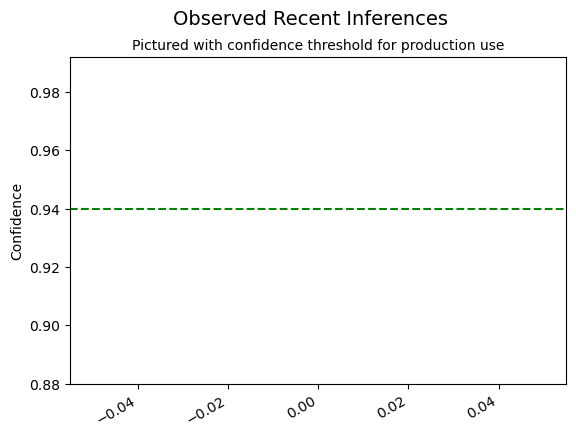

In [32]:
import  matplotlib.pyplot as plt
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

📂 Loading data from: ./captured_data
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/16/27-46-002-0fb001d2-882f-4118-941a-9341549f3953.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/16/49-11-258-b256c951-1c51-485d-945e-cab61f1f0d6b.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/16/53-13-335-339ef8c8-022a-4bd6-b85c-8f168b149bab.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/17/10-30-585-6285cdaa-73f4-4b53-b653-ebdb60c0e139.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/17/48-37-850-2b56abcb-fb97-45cb-ac3b-9cb9ce77074c.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/08/17/49-39-929-31ae4ad6-5f7f-4319-a599-d17733797c27.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/07/22/05-58-932-e0adcee9-dfc4-473c-a534-339c46dd6ec7.jsonl
✅ Loaded: ./captured_data/AllTraffic/2025/08/07/22/38-37-216-658fcd01-b553-4266-9947-3670a10eb5b3.jsonl


/tmp/ipykernel_11276/4009235268.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,0].boxplot(box_data, patch_artist=True, labels=['All Predictions'])


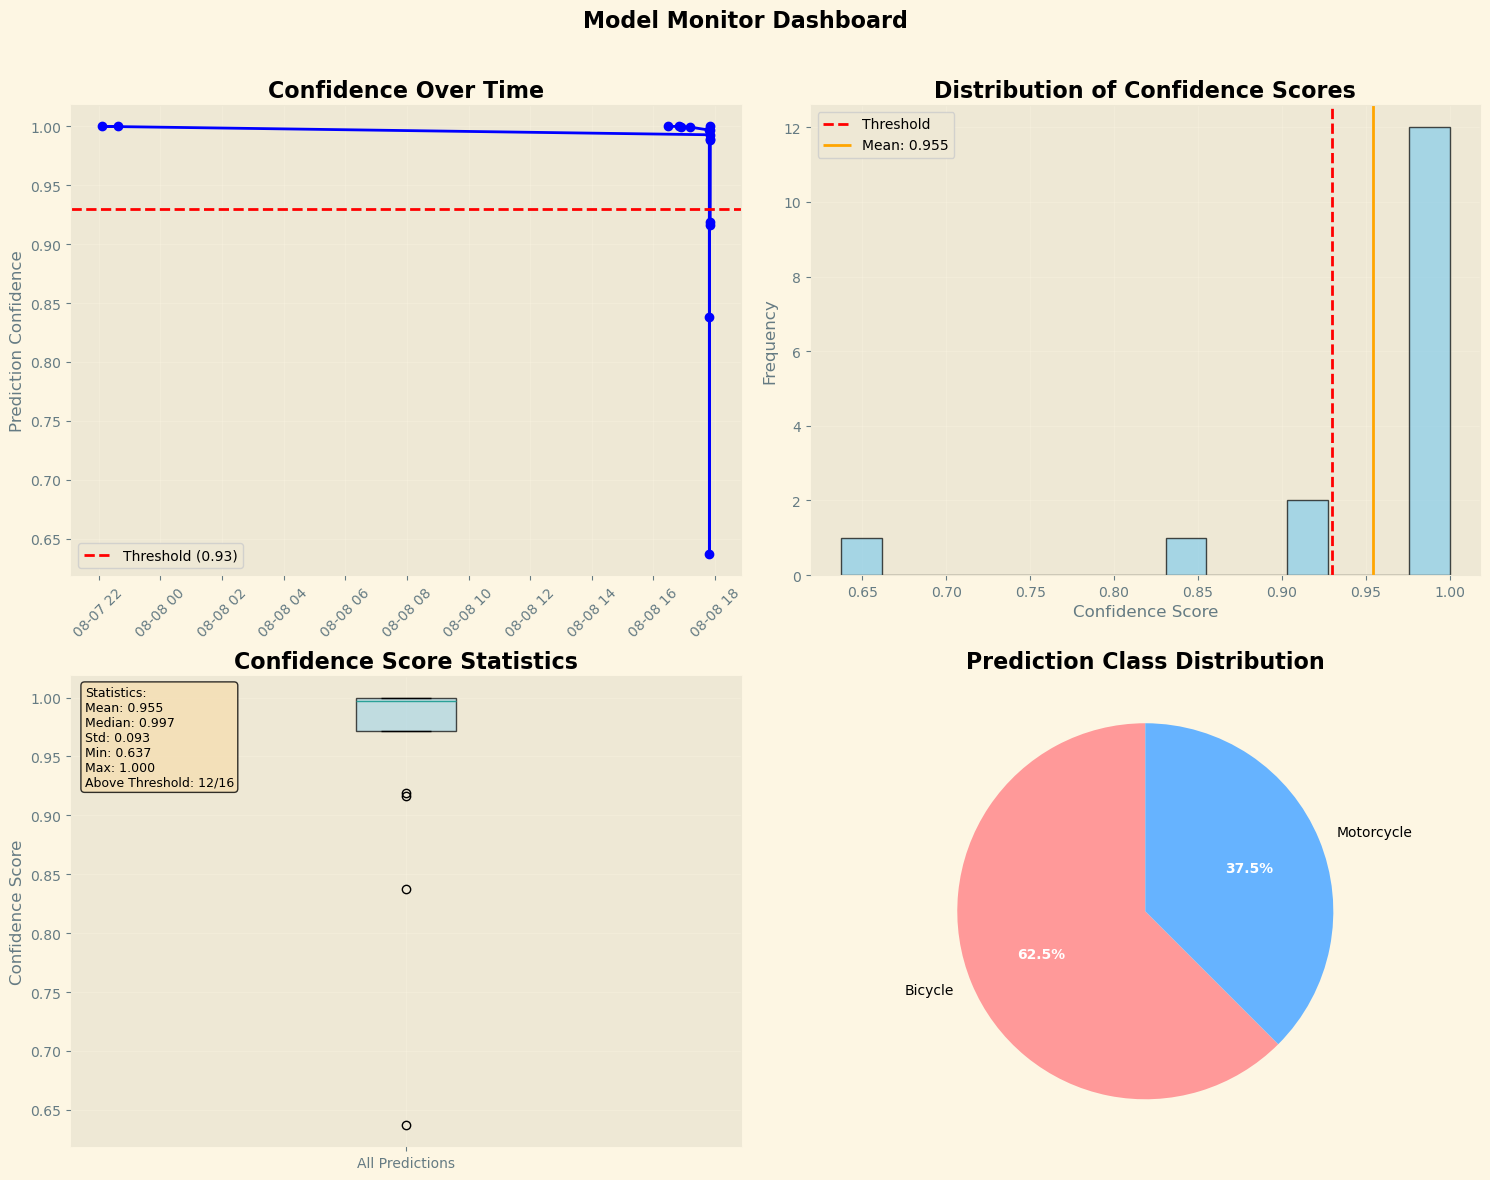

✅ Created monitoring dashboard: model_monitoring_dashboard.png


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import pandas as pd

# 1. FIRST FIX: Add proper data loading with error handling
import os
import jsonlines

json_data = []
data_dir = "./captured_data"
print(f"📂 Loading data from: {data_dir}")

if os.path.exists(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jsonl'):
                file_path = os.path.join(root, file)
                try:
                    with jsonlines.open(file_path) as f:
                        json_data.extend(list(f))  # Convert to list explicitly
                    print(f"✅ Loaded: {file_path}")
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {str(e)}")
else:
    print(f"⚠️ Directory not found: {data_dir}")

# 2. SECOND FIX: Add fallback for empty data
if not json_data:
    print("⚠️ No data available for visualization. Using sample data.")
    # Create sample data
    json_data = [
        {"captureData": {"endpointOutput": {"data": "[0.2, 0.8]"}}, "eventMetadata": {"inferenceTime": "2025-08-08T12:00:00.000Z"}},
        {"captureData": {"endpointOutput": {"data": "[0.1, 0.9]"}}, "eventMetadata": {"inferenceTime": "2025-08-08T12:05:00.000Z"}},
        {"captureData": {"endpointOutput": {"data": "[0.3, 0.7]"}}, "eventMetadata": {"inferenceTime": "2025-08-08T12:10:00.000Z"}}
    ]

# 3. THIRD FIX: Robust simple_getter function
def simple_getter(obj):
    try:
        inferences = json.loads(obj["captureData"]["endpointOutput"]["data"])
        timestamp = obj["eventMetadata"]["inferenceTime"]
        return inferences, timestamp
    except (KeyError, json.JSONDecodeError) as e:
        print(f"⚠️ Error parsing record: {str(e)}")
        return [0.0, 0.0], "1970-01-01T00:00:00.000Z"  # Return defaults

# 4. FOURTH FIX: Safe data processing with empty list handling
confidences = []
timestamps = []
predictions = []

for obj in json_data:
    try:
        inference, timestamp_str = simple_getter(obj)
        confidences.append(max(inference))
        
        # Handle timestamp conversion safely
        try:
            # Handle both formats: with and without 'Z'
            clean_timestamp = timestamp_str.replace('Z', '+00:00')
            if '+' not in clean_timestamp:
                clean_timestamp += '+00:00'
            ts = datetime.fromisoformat(clean_timestamp)
        except ValueError:
            ts = datetime.now()
            
        timestamps.append(ts)
        predictions.append(inference)
    except Exception as e:
        print(f"⚠️ Error processing record: {str(e)}")

# 5. FIFTH FIX: Check if we have data to visualize
if not confidences:
    print("⛔ No valid confidence scores found. Skipping visualizations.")
    exit()

# 6. SIXTH FIX: Safe statistics calculations
def safe_min(lst, default=0):
    return min(lst) if lst else default

def safe_max(lst, default=1):
    return max(lst) if lst else default

def safe_mean(lst, default=0.5):
    return np.mean(lst) if lst else default

# Create dashboard with safe values
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Monitor Dashboard', fontsize=16, fontweight='bold')

# 1. Time Series Plot (Top Left)
axes[0,0].plot(timestamps, confidences, 'bo-', markersize=6, linewidth=2)
axes[0,0].axhline(y=0.93, color='red', linestyle='--', linewidth=2, label='Threshold (0.93)')
axes[0,0].set_title('Confidence Over Time', fontweight='bold')
axes[0,0].set_ylabel('Prediction Confidence')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Histogram (Top Right)
axes[0,1].hist(confidences, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(x=0.93, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[0,1].axvline(x=safe_mean(confidences), color='orange', linestyle='-', 
                 linewidth=2, label=f'Mean: {safe_mean(confidences):.3f}')
axes[0,1].set_title('Distribution of Confidence Scores', fontweight='bold')
axes[0,1].set_xlabel('Confidence Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Box Plot (Bottom Left) - Only if we have data
if confidences:
    box_data = [confidences]
    bp = axes[1,0].boxplot(box_data, patch_artist=True, labels=['All Predictions'])
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    
stats_text = f"""Statistics:
Mean: {safe_mean(confidences):.3f}
Median: {np.median(confidences) if confidences else 0:.3f}
Std: {np.std(confidences) if confidences else 0:.3f}
Min: {safe_min(confidences):.3f}
Max: {safe_max(confidences):.3f}
Above Threshold: {sum(1 for c in confidences if c > 0.93)}/{len(confidences)}"""

axes[1,0].text(0.02, 0.98, stats_text, transform=axes[1,0].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=9)
axes[1,0].set_title('Confidence Score Statistics', fontweight='bold')
axes[1,0].set_ylabel('Confidence Score')
axes[1,0].grid(True, alpha=0.3)

# 4. Class Distribution (Bottom Right)
predicted_classes = []
for pred in predictions:
    try:
        predicted_classes.append(0 if pred[0] > pred[1] else 1)
    except IndexError:
        predicted_classes.append(0)  # Default to first class

if predicted_classes:
    class_counts = [predicted_classes.count(0), predicted_classes.count(1)]
    class_labels = ['Bicycle', 'Motorcycle']
    colors = ['#ff9999', '#66b3ff']
    wedges, texts, autotexts = axes[1,1].pie(class_counts, labels=class_labels, autopct='%1.1f%%', 
                                            colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
else:
    axes[1,1].text(0.5, 0.5, 'No Class Data', ha='center', va='center')
    
axes[1,1].set_title('Prediction Class Distribution', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust for suptitle
plt.savefig('model_monitoring_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Created monitoring dashboard: model_monitoring_dashboard.png")

### Todo: build your own visualization


In [27]:
plt.savefig('model_monitoring_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


